In [1]:
import sys
sys.path.append('../')

from model import DecisionTree
from rule import RuleExtractor

import os
import numpy as np
import warnings
import pandas as pd

np.set_printoptions(suppress=True)

warnings.filterwarnings(action='ignore')

In [2]:
# sage, srgnn 중 선택
embed_model = 'srgnn'
filename = {'sage' : 'user_embedding_sage_sid_6to6_weighted.npy', 'srgnn' : 'srgnn_user_hybrid_6to6_weighted.npy'}
data_path = "../data/"

pivot_df = pd.read_csv(os.path.join(data_path, 'pivot_genre2_data.csv'), index_col=0)
embedding = np.load(os.path.join(data_path, filename[embed_model]))

# One vs Rest Decision Tree

In [ ]:
import os

model = DecisionTree(pivot_df, embedding)
k = 15
result = []
for i in range(k):
    model.kmeans_target(i)
    max_depth, max_score = model.get_proper_depth(target_score=1.0, scoring='f1_score')

    result.append((max_depth, max_score))
    print(max_depth, max_score)

    rule_extractor = RuleExtractor(model)
    rules = rule_extractor.extract_rule(segment_num=1)
    
    save_dir = f'../output/{embed_model}_rule'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    with open(save_dir + f'/{embed_model}_1vsall_seg_rule_extract{i}.txt', 'w') as f:
        f.writelines(rules)

In [ ]:
# one vs rest decision tree 평균 depth
np.mean([r[0] for r in result])

# Multi-Class Decision Tree

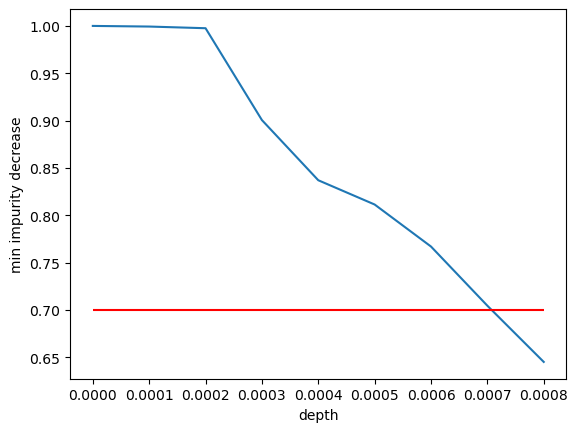

0.0007 0.7044808007770297


In [3]:
# model = DecisionTree(pivot_df, embedding)
# max_depth, max_score = model.get_proper_depth(target_score=0.6, scoring='f1_score')
# print(max_depth, max_score)
# model = DecisionTree(pivot_df, embedding)
# proper_mss, max_score = model.get_proper_min_sample_split(target_score=0.7, scoring='precision')
# print(proper_mss, max_score)
model = DecisionTree(pivot_df, embedding)
proper_mid, max_score = model.get_proper_min_impurity_decrease(target_score=0.7, scoring='precision')
print(proper_mid, max_score)
# model = DecisionTree(pivot_df, embedding)
# proper_ccp, max_score = model.get_proper_cost_complexity_pruning(target_score=0.7, scoring='precision')
# print(proper_ccp, max_score)

In [4]:
k=15
len_or_list = []
save_dir = f'../output/{embed_model}_rule'

for i in range(k):
    rule_extractor = RuleExtractor(model)
    rules = rule_extractor.extract_rule(segment_num=i)
    
    or_list = rules.split('[OR]')

    ls = [[r.split() for r in l.split('[AND]')] for l in or_list]
    new_ls = []
    for node in ls:
        new_ls.append([])
        rule_dic = {}
        for r in node:
            key_name = f'{r[0]} {r[1]} '
            rule_dic[key_name] = rule_dic.get(key_name, [])
            rule_dic[key_name].append(float(r[2]))    
        
        for k, v in rule_dic.items():
            if k in '>':
                rule_dic[k] = max(v)
            else:
                rule_dic[k] = min(v)
        
        for k, v in rule_dic.items():
            new_rule = k.split()
            new_rule.append(str(v))
            new_ls[-1].append(new_rule)
            
    # 생성 규칙 수
    total_rule_ls = []
    for node in new_ls:
        for rule in node:
            total_rule_ls.append(str(rule))
    
    node_list = []
    for node in new_ls:
        rule_list = []
        for rule in node:
            rule_list.append(''.join(rule))
        node_rule = ' [AND] '.join(rule_list)
        node_list.append(node_rule)
    total_rule = ' [OR]\n'.join(node_list)

    with open(save_dir + f'/{embed_model}_seg_rule_extract{i}.txt', 'w') as f:
        f.writelines(total_rule)

In [6]:
pred_df = pivot_df.copy()

pred_df['label'] = model.Y
pred_df['prediction'] = model.max_depth_dt.predict(pivot_df)

label = pred_df['label'].value_counts().sort_index()
prediction = pred_df['prediction'].value_counts().sort_index()

for y_true, y_pred in zip(label, prediction):
    print(y_pred)

343
490
63
335
512
117
377
59
266
710
99
118
529
95
695


## segment 1로 실험해보기
- 집합 줄이고
- set으로

In [ ]:
i = 1
f = open(f'../output/{embed_model}_rule/{embed_model}_seg_rule_extract{i}.txt', 'r')
ls = [[r.split() for r in l.split('[AND]')] for l in f.read().split('[OR]')]
ls

In [ ]:
sss = set()
for node in ls:
    for r in node:
        sss.add(r[1])
sss

In [ ]:
i = 1 # 세그멘트 1에 대해서 실험
f = open(f'../output/{embed_model}_rule/{embed_model}_seg_rule_extract{i}.txt', 'r')
ls = [[r.split() for r in l.split('[AND]')] for l in f.read().split('[OR]')]
new_ls = []
for node in ls:
    new_ls.append([])
    rule_dic = {}
    for r in node:
        key_name = f'{r[0]} {r[1]} '
        rule_dic[key_name] = rule_dic.get(key_name, [])
        rule_dic[key_name].append(float(r[2]))    
    
    for k, v in rule_dic.items():
        if k in '>':
            rule_dic[k] = max(v)
        else:
            rule_dic[k] = min(v)
    
    for k, v in rule_dic.items():
        new_rule = k.split()
        new_rule.append(str(v))
        new_ls[-1].append(new_rule)
new_ls

In [ ]:
# 기존 방법
total_rule_ls = []
for node in ls:
    for rule in node:
        total_rule_ls.append(str(rule))
print(len(total_rule_ls)) # 리스트에서 생성 규칙 수
print(len(set(total_rule_ls))) # set에서 생성 규칙 수

In [ ]:
# 새로운 방법
total_rule_ls = []
for node in new_ls:
    for rule in node:
        total_rule_ls.append(str(rule))
print(len(total_rule_ls)) # 리스트에서 생성 규칙 수
print(len(set(total_rule_ls))) # set에서 생성 규칙 수